In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
import catboost

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

In [3]:
df_2015 = pd.read_csv('2015.csv', low_memory=False)
df_2016 = pd.read_csv('2016.csv', low_memory=False)
df_2017 = pd.read_csv('2017.csv', low_memory=False)

In [4]:
df = pd.concat([df_2015, df_2016, df_2017]).reset_index(drop=True)

In [5]:
df = df[['FL_DATE','OP_CARRIER', 'ORIGIN', 'DEST','DISTANCE',
        'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
        'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
        'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']]

In [6]:
df.columns = ['date','airline_id', 'origin_airport', 'destination_airport','distance',
        'scheduled_departure', 'actual_departure', 'departure_delay',
        'scheduled_arrival', 'actual_arrival', 'arrival_delay',
        'scheduled_elapsed', 'actual_elapsed']

In [7]:
df = df.dropna(subset=['actual_elapsed'])

In [8]:
df = df[['date','airline_id', 'origin_airport', 'destination_airport','distance',
        'scheduled_departure',
        'scheduled_arrival', 'arrival_delay',
        'scheduled_elapsed']]

In [9]:
df['date'] = pd.to_datetime(df.date)

In [10]:
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year 
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df['is_holiday'] = df['date'].isin([d.date() for d in cal.holidays()])

In [11]:
from catboost import CatBoostRegressor, Pool

In [12]:
df_train = df[df.year == 2015]
df_test = df[df.year == 2016]
df_val = df[df.year == 2017]

In [13]:
X_train = df_train.drop(columns=['arrival_delay','date'])
y_train = df_train['arrival_delay']

X_test = df_test.drop(columns=['arrival_delay','date'])
y_test = df_test['arrival_delay']

X_val = df_val.drop(columns=['arrival_delay','date'])
y_val = df_val['arrival_delay']

In [14]:
cat_features = ['airline_id', 'origin_airport', 'destination_airport','is_holiday']

In [28]:
model = CatBoostRegressor(iterations=100,
                          learning_rate=0.1,
                          loss_function='RMSE',
                         task_type="GPU",
                           devices='0')

In [19]:
pool = Pool(X_train, y_train, cat_features=cat_features)

In [29]:
model.fit(pool, eval_set=[(X_test,y_test)],plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 39.1684309	test: 41.7812532	best: 41.7812532 (0)	total: 199ms	remaining: 19.7s
1:	learn: 39.0846263	test: 41.7047274	best: 41.7047274 (1)	total: 389ms	remaining: 19.1s
2:	learn: 38.9421262	test: 41.6453578	best: 41.6453578 (2)	total: 562ms	remaining: 18.2s
3:	learn: 38.8347787	test: 41.5679880	best: 41.5679880 (3)	total: 736ms	remaining: 17.7s
4:	learn: 38.7693201	test: 41.5234028	best: 41.5234028 (4)	total: 908ms	remaining: 17.2s
5:	learn: 38.7156547	test: 41.5177183	best: 41.5177183 (5)	total: 1.08s	remaining: 16.9s
6:	learn: 38.6685796	test: 41.5148612	best: 41.5148612 (6)	total: 1.25s	remaining: 16.6s
7:	learn: 38.6357617	test: 41.5004417	best: 41.5004417 (7)	total: 1.42s	remaining: 16.3s
8:	learn: 38.5900927	test: 41.5028921	best: 41.5004417 (7)	total: 1.6s	remaining: 16.2s
9:	learn: 38.5673309	test: 41.5058034	best: 41.5004417 (7)	total: 1.75s	remaining: 15.8s
10:	learn: 38.5420344	test: 41.5004150	best: 41.5004150 (10)	total: 1.92s	remaining: 15.5s
11:	learn: 38.513826

92:	learn: 37.8601755	test: 41.5356932	best: 41.4932747 (35)	total: 16s	remaining: 1.21s
93:	learn: 37.8549636	test: 41.5382861	best: 41.4932747 (35)	total: 16.2s	remaining: 1.03s
94:	learn: 37.8518130	test: 41.5378655	best: 41.4932747 (35)	total: 16.4s	remaining: 862ms
95:	learn: 37.8490870	test: 41.5388715	best: 41.4932747 (35)	total: 16.5s	remaining: 689ms
96:	learn: 37.8452753	test: 41.5416779	best: 41.4932747 (35)	total: 16.7s	remaining: 517ms
97:	learn: 37.8403384	test: 41.5480066	best: 41.4932747 (35)	total: 16.9s	remaining: 344ms
98:	learn: 37.8365293	test: 41.5508480	best: 41.4932747 (35)	total: 17.1s	remaining: 172ms
99:	learn: 37.8332694	test: 41.5545569	best: 41.4932747 (35)	total: 17.2s	remaining: 0us
bestTest = 41.49327467
bestIteration = 35
Shrink model to first 36 iterations.


In [87]:
interactions = model.get_feature_importance(pool, fstr_type=catboost.EFstrType.Interaction, prettified=True)

In [90]:
feature_interaction = [[X_train.columns[interaction[0]], X_train.columns[interaction[1]], interaction[2]] for i,interaction in interactions.iterrows()]
feature_interaction_df = pd.DataFrame(feature_interaction, columns=['feature1', 'feature2', 'interaction_strength'])

In [91]:
feature_interaction_df.head(10)

feature1             feature2  interaction_strength
0       dayofyear           weekofyear              6.769630
1       dayofyear           dayofmonth              6.402237
2  origin_airport            dayofyear              5.138724
3      airline_id           weekofyear              4.635254
4      airline_id       origin_airport              4.474357
5       dayofweek            dayofyear              4.472855
6      airline_id            dayofyear              4.086714
7      airline_id  destination_airport              3.713611
8      airline_id  scheduled_departure              2.807504
9      dayofmonth           weekofyear              2.757010

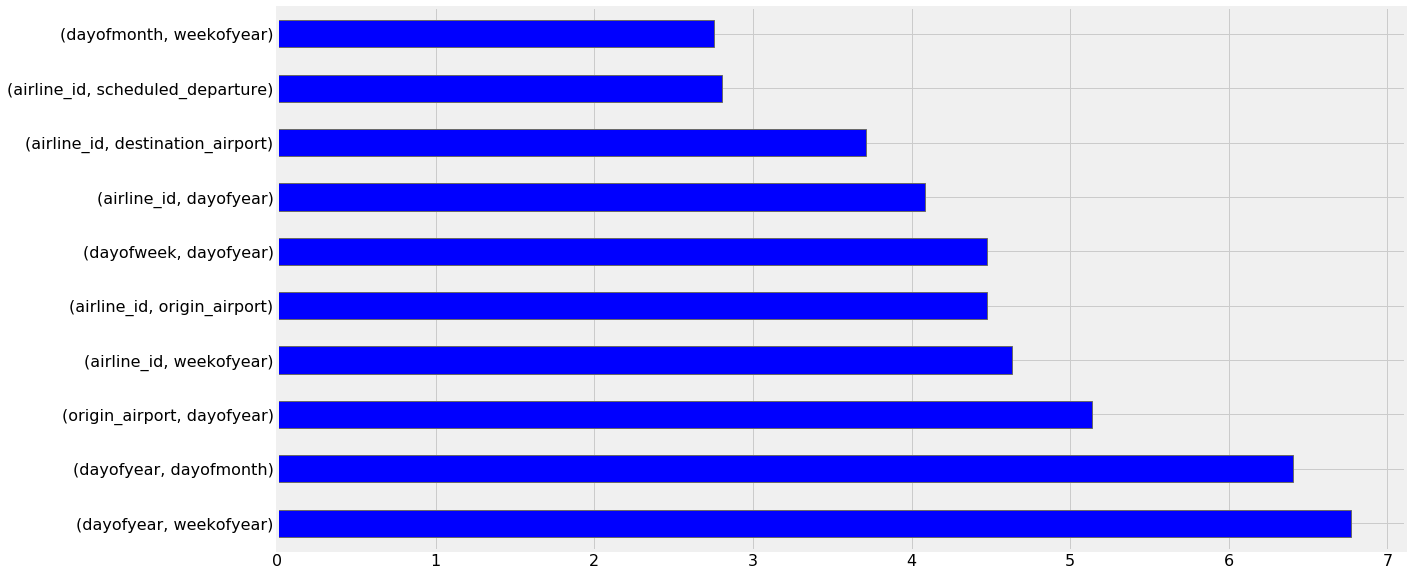

In [92]:
pd.Series(index=zip(feature_interaction_df['feature1'], feature_interaction_df['feature2']), data=feature_interaction_df['interaction_strength'].values, name='interaction_strength').head(10).plot(kind='barh', figsize=(18, 10), fontsize=16, color='b')

In [107]:
shap.initjs()

In [108]:
explainer = shap.TreeExplainer(model)

In [109]:
shap_values = explainer.shap_values(pool)

In [110]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [111]:
shap.force_plot(explainer.expected_value, shap_values[4,:], X_train.iloc[4,:])

In [112]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[0:50,:], X_train.iloc[0:50,:])

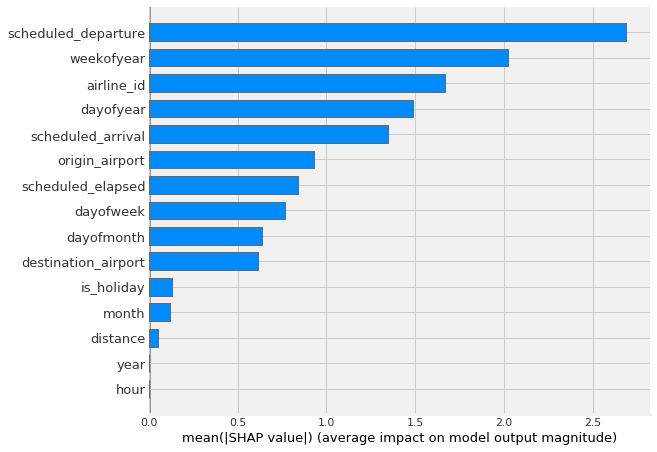

In [113]:
# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

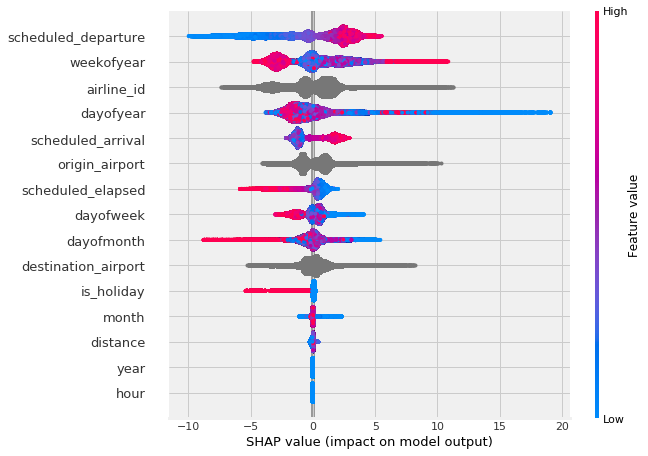

In [114]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [21]:
X_test_result = X_test.copy()

In [22]:
X_test_result['y_pred'] = y_train.median()
rmse = mean_squared_error(y_test, X_test_result['y_pred'] , squared=False)
rmse

42.73116716756057

In [121]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred , squared=False)
rmse

41.47195936543368

In [24]:
X_val_result = X_val.copy()

In [25]:
X_val_result['y_pred'] = y_train.median()
rmse = mean_squared_error(y_val, X_val_result['y_pred'] , squared=False)
rmse

46.80343775562187

In [119]:
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred , squared=False)
rmse

45.371054276627284